In [24]:
import torch, open_clip, torchvision
from transformers import AutoProcessor,CLIPVisionModelWithProjection,CLIPModel
from PIL import Image
from huggingface_hub import hf_hub_download
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import clip, cv2
import numpy as np
import json
import rasterio as rio
from sklearn.metrics import f1_score, accuracy_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from torchvision import transforms
import os
import skimage.io as io
from matplotlib import patches
device = 'cuda:3'



In [ ]:
emb_path = "./Lucas_Frozen_Embeddings/lucas_swen_hfclipemb512_ViTB32.pt"
lucas_emb_dict = torch.load(emb_path, map_location= 'cpu')

key_list = list(lucas_emb_dict.keys())
emb_list = list(lucas_emb_dict.values())
emb_tensor = torch.cat(emb_list).to(device)

In [ ]:
version="SenCLIP_AttPool"#SenCLIP_AvgPool, SenCLIP_AttPool
mean, std = (0.347, 0.376, 0.296), (0.269, 0.261, 0.276)


if 'AttPool' in version:
    weight_path = './SenCLIP_AttPoolPerImg_ViTB32.ckpt'
if 'AvgPool' in version:
    weight_path = "./SenCLIP_AvgPool_ViTB32.ckpt"


In [27]:
device = "cuda:3" #if is_gpu else "cpu"
model_name = 'ViT-B/32'
model, preprocess = clip.load(model_name,  device=device, jit=False)   
checkpoint = torch.load(weight_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint, strict=True)
model.to(device).eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [28]:
transform = transforms.Compose([
        transforms.Resize((224, 224), interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

In [ ]:
# eurosat_root = '/home/pallavi/DATA/Datasets/EuroSAT/2750'
# eurosat_emb = {}
# for cls_fold in os.listdir(eurosat_root):
#     print(cls_fold)
#     for paths in os.listdir(os.path.join(eurosat_root, cls_fold)):
#         image_path = os.path.join(eurosat_root, cls_fold, paths)
#         image = io.imread(image_path)
#         pil_image = Image.fromarray(image)
#         image_t = transform(pil_image).unsqueeze(0).to(device)
#         with torch.no_grad():
#             image_features = model.encode_image(image_t)
#             image_features /= image_features.norm(dim=-1, keepdim=True)
            
#             eurosat_emb[f"{cls_fold}/{paths}"]=image_features

# torch.save(eurosat_emb,f"./emb_logits/eurosat_{version}.pt")

In [ ]:
eurosat_emb = torch.load(f"./emb_logits/eurosat_{version}.pt")

In [ ]:
images_path = ['./EuroSAT/2750/AnnualCrop/AnnualCrop_13.jpg',
                './EuroSAT/2750/Forest/Forest_51.jpg',
                './EuroSAT/2750/HerbaceousVegetation/HerbaceousVegetation_55.jpg',
                './EuroSAT/2750/Highway/Highway_14.jpg',
                './EuroSAT/2750/Industrial/Industrial_9.jpg',
                # './EuroSAT/2750/Pasture/Pasture_12.jpg',
                # './EuroSAT/2750/PermanentCrop/PermanentCrop_17.jpg',
                # './EuroSAT/2750/Residential/Residential_11.jpg',
                # './EuroSAT/2750/River/River_8.jpg',
                './EuroSAT/2750/SeaLake/SeaLake_230.jpg'
                ]
eurosat_root = "./EuroSAT/2750/"
lucas_root ='./gisco-services.ec.europa.eu/lucas/photos/2018/'

In [32]:
NEW_CNAMES = {
    'AnnualCrop': 'Annual \n Crop',
    'Forest': 'Forest',
    'HerbaceousVegetation': 'Herbaceous \n Vegetation',#'Brushland or Shrubland', #'Herbaceous Vegetation Land',
    'Highway': 'Highway \n or Road',
    'Industrial': 'Industrial \n Buildings',
    'Pasture': 'Pasture',
    'PermanentCrop': 'Permanent \n Crop',
    'Residential': 'Residential \n Buildings',
    'River': 'River',
    'SeaLake': 'Sea \n or Lake'
}

### EuroSAT to LUCAS

(64, 64, 3)
tensor([[811010, 387418, 747576]], device='cuda:3')
['/home/pallavi/DATA/Datasets/gisco-services.ec.europa.eu/lucas/photos/2018/PL/520/434/52043484W.jpg', '/home/pallavi/DATA/Datasets/gisco-services.ec.europa.eu/lucas/photos/2018/IT/414/224/41422420W.jpg', '/home/pallavi/DATA/Datasets/gisco-services.ec.europa.eu/lucas/photos/2018/PL/503/633/50363352S.jpg']
(64, 64, 3)
tensor([[585800, 684949, 715825]], device='cuda:3')
['/home/pallavi/DATA/Datasets/gisco-services.ec.europa.eu/lucas/photos/2018/PL/465/633/46563316W.jpg', '/home/pallavi/DATA/Datasets/gisco-services.ec.europa.eu/lucas/photos/2018/PL/486/432/48643238E.jpg', '/home/pallavi/DATA/Datasets/gisco-services.ec.europa.eu/lucas/photos/2018/PL/494/833/49483396N.jpg']
(64, 64, 3)
tensor([[917650, 104216, 928277]], device='cuda:3')
['/home/pallavi/DATA/Datasets/gisco-services.ec.europa.eu/lucas/photos/2018/BG/561/222/56122222S.jpg', '/home/pallavi/DATA/Datasets/gisco-services.ec.europa.eu/lucas/photos/2018/ES/321/019/32101

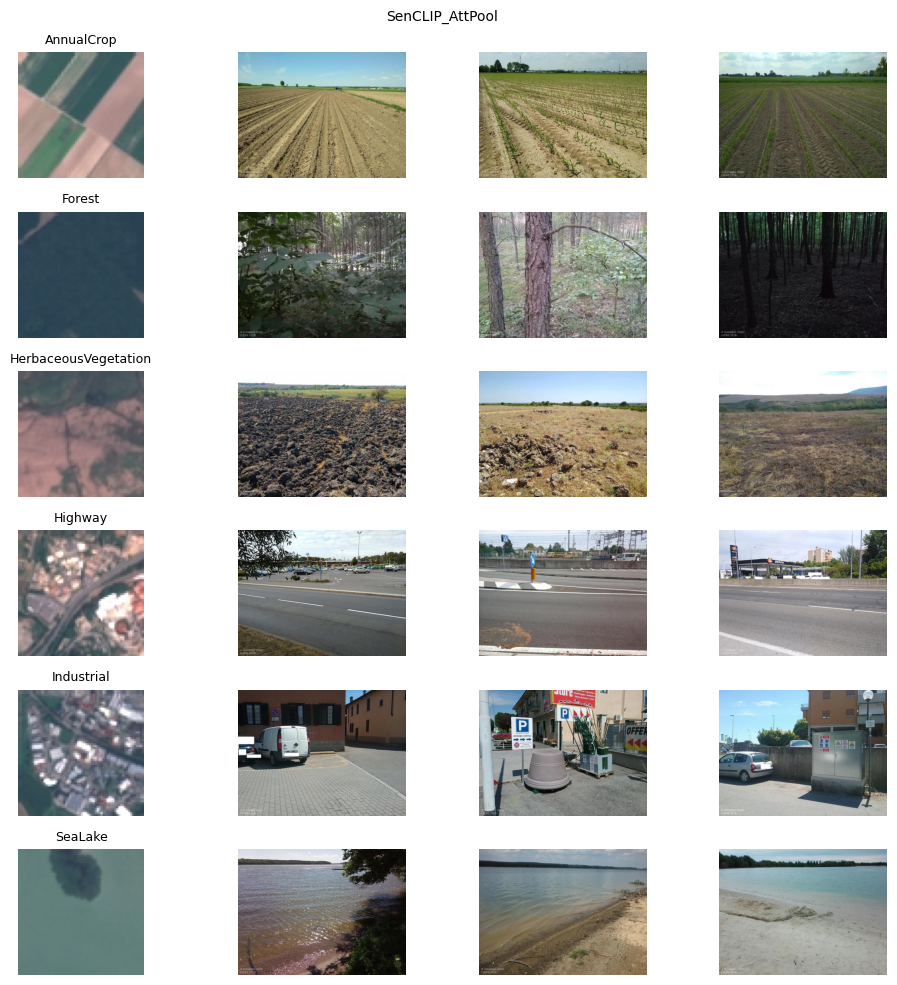

In [ ]:
num_images = len(images_path)
num_cols = 4  # Number of columns (image and text)
num_rows = num_images  # Number of rows equals the number of images
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
fig.suptitle(version, fontsize=10)

lucas_list = []
for i, image_path in enumerate(images_path):
    prompt_select = []
    image_name = image_path.split('/')[-2]
    img_path = f"{image_name}/{image_path.split('/')[-1]}"
    image = io.imread(image_path)
   
    print(image.shape)
    with torch.no_grad():
        image_features = eurosat_emb[img_path].to(device)
        emb_tensor /= emb_tensor.norm(dim=-1, keepdim=True)
        logits = (image_features.float() @ emb_tensor.T)/2+1

      
    _,top_indx = logits.topk(3)
    print(top_indx)
    #AT/481/628/48162806N.jpg
    key_select = [f"{lucas_root}{key_list[i].split('_')[0]}/{key_list[i].split('_')[1][:3]}/{key_list[i].split('_')[1][3:6]}/{key_list[i].split('_')[1]}.jpg" for i in top_indx[0]]
    print(key_select)
    lucas_list.append(key_select)
    image_top1 = io.imread(key_select[0])
    image_top2 = io.imread(key_select[1])
    image_top3 = io.imread(key_select[2])
    # # Display the image
    # # image = torch.transpose(image, 1,3)
    axs[i, 0].imshow(image)
    axs[i, 0].set_title(image_name,fontsize=9)
    axs[i, 0].axis('off')
    

    axs[i, 1].imshow(image_top1)
    axs[i, 1].axis('off')

    axs[i, 2].imshow(image_top2)
    axs[i, 2].axis('off')

    axs[i, 3].imshow(image_top3)
    axs[i, 3].axis('off')

    
plt.tight_layout()
plt.show()
 

### LUCAS to EuroSAT

In [ ]:
lucas_image_paths = [
    './gisco-services.ec.europa.eu/lucas/photos/2018/AT/481/628/48162806N.jpg',
    # './gisco-services.ec.europa.eu/lucas/photos/2018/AT/481/628/48162806W.jpg',
# './gisco-services.ec.europa.eu/lucas/photos/2018/PL/490/632/49063212N.jpg',
# './gisco-services.ec.europa.eu/lucas/photos/2018/PL/520/434/52043484W.jpg',
# './gisco-services.ec.europa.eu/lucas/photos/2018/PL/503/633/50363352S.jpg',
 './gisco-services.ec.europa.eu/lucas/photos/2018/HU/492/625/49262574N.jpg',
 './gisco-services.ec.europa.eu/lucas/photos/2018/BG/577/023/57702374E.jpg',
 './gisco-services.ec.europa.eu/lucas/photos/2018/FR/399/022/39902232S.jpg',
 './gisco-services.ec.europa.eu/lucas/photos/2018/DE/415/030/41503034E.jpg',
#  './gisco-services.ec.europa.eu/lucas/photos/2018/UK/329/436/32943604W.jpg',
#  './gisco-services.ec.europa.eu/lucas/photos/2018/NL/403/231/40323182W.jpg',
#  './gisco-services.ec.europa.eu/lucas/photos/2018/HR/500/624/50062480E.jpg',
#  './gisco-services.ec.europa.eu/lucas/photos/2018/DE/410/431/41043158E.jpg',
 './gisco-services.ec.europa.eu/lucas/photos/2018/HR/469/424/46942420N.jpg']

(512, 512, 3)
tensor([[26235, 25071, 25815]], device='cuda:3')
['/home/pallavi/DATA/Datasets/EuroSAT/2750/AnnualCrop/AnnualCrop_2730.jpg', '/home/pallavi/DATA/Datasets/EuroSAT/2750/AnnualCrop/AnnualCrop_2899.jpg', '/home/pallavi/DATA/Datasets/EuroSAT/2750/AnnualCrop/AnnualCrop_1474.jpg']
(384, 512, 3)
tensor([[2261, 2519, 2866]], device='cuda:3')
['/home/pallavi/DATA/Datasets/EuroSAT/2750/Forest/Forest_111.jpg', '/home/pallavi/DATA/Datasets/EuroSAT/2750/Forest/Forest_2293.jpg', '/home/pallavi/DATA/Datasets/EuroSAT/2750/Forest/Forest_1360.jpg']
(384, 512, 3)
tensor([[24488, 24212,  9926]], device='cuda:3')
['/home/pallavi/DATA/Datasets/EuroSAT/2750/AnnualCrop/AnnualCrop_2001.jpg', '/home/pallavi/DATA/Datasets/EuroSAT/2750/AnnualCrop/AnnualCrop_397.jpg', '/home/pallavi/DATA/Datasets/EuroSAT/2750/HerbaceousVegetation/HerbaceousVegetation_55.jpg']
(384, 512, 3)
tensor([[16550, 16549, 16121]], device='cuda:3')
['/home/pallavi/DATA/Datasets/EuroSAT/2750/Highway/Highway_455.jpg', '/home/palla

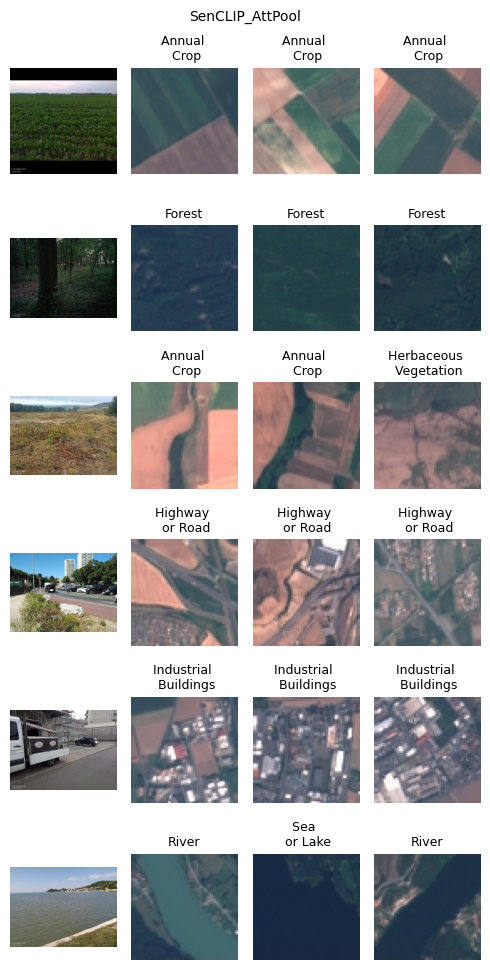

In [ ]:

num_images = len(images_path)
num_cols = 4  # Number of columns (image and text)
num_rows = num_images  # Number of rows equals the number of images
fig, axs = plt.subplots(num_rows, num_cols, figsize=(5, 10))
fig.suptitle(version, fontsize=10)
emb_list_euro = list(eurosat_emb.values())
key_list_euro = list(eurosat_emb.keys())
emb_tensor_euro = torch.cat(emb_list_euro).to(device)

lucas_list = []
for i, image_path in enumerate(lucas_image_paths):
    prompt_select = []
    image_name = image_path.split('/')[-2]
    image = io.imread(image_path)
    pil_image = Image.fromarray(image)
    image_t = transform(pil_image).unsqueeze(0).to(device)
    print(image.shape)
    with torch.no_grad():
        # image_features = model.encode_image(image_t).float()
      
        name = f"{image_path.split('/')[-4]}_{image_path.split('/')[-1].split('.')[0]}"
        image_features = lucas_emb_dict[name].to(device)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        logits = (image_features @ emb_tensor_euro.float().T)/2+1

      
    _,top_indx = logits.topk(3)
    print(top_indx)
    #AT/481/628/48162806N.jpg
    key_select = [f"{eurosat_root}{key_list_euro[i]}" for i in top_indx[0]]
    print(key_select)
    image_top1 = io.imread(key_select[0])
    image_top2 = io.imread(key_select[1])
    image_top3 = io.imread(key_select[2])
    # # Display the image
    # # image = torch.transpose(image, 1,3)
    axs[i, 0].imshow(image)
    # axs[i, 0].set_title(image_name)
    axs[i, 0].axis('off')

    axs[i, 1].imshow(image_top1)
    axs[i, 1].set_title(NEW_CNAMES[key_select[0].split("/")[-2]],fontsize=9)
    axs[i, 1].axis('off')

    axs[i, 2].imshow(image_top2)
    axs[i, 2].set_title(NEW_CNAMES[key_select[1].split("/")[-2]],fontsize=9)
    axs[i, 2].axis('off')

    axs[i, 3].imshow(image_top3)
    axs[i, 3].set_title(NEW_CNAMES[key_select[2].split("/")[-2]],fontsize=9)
    axs[i, 3].axis('off')

plt.tight_layout()
plt.show()
